<a href="https://colab.research.google.com/github/yihan-zhou/fastai/blob/main/week5_class_notes_using_frameworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ensembling, this means creating multiple models and combine their predictions
# Some data pre-processing: fill the na cells, log the columns with bigger change, encode the categorical columns

In [2]:
import pandas as pd

In [1]:
from fastai.tabular.all import *
pd.options.display.float_format = '{:,.2f}'.format
set_seed(42)

In [3]:
path = "train.csv"
df = pd.read_csv(path)

In [4]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [10]:
# Survived is the target column.
# Name could be dropped.
# Sex is to encoded with category.
# Fare has a pretty big range and could use log to minimize the impact of bigger values.
# Features to be added: family count(siblings and parents / children aboard), alone, ticketfreq (the frenquency of the ticket), title (mr, miss, mrs, master)
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    # .groupby():  it organizes the rows of the DataFrame based on the unique values in the 'Ticket' column.
    # ['Ticket'].transform('count'):  It selects the 'Ticket' column within each group and then applies the count function.
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")).value_counts(dropna=False)
    # dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master") is a Python dictionary that defines a mapping.
    # .map(): takes each value of title column and replace it with the corresponding value. if nothing found, it adds Nan

add_features(df)

In [11]:
splits = RandomSplitter(seed=42)(df)

In [12]:
dls = TabularPandas(
    df,splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names='Survived',
    y_block = CategoryBlock(),
).dataloaders(path = ".")

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


## Train the model

In [14]:
learn =tabular_learner(dls, layers=[10,10], metrics=accuracy)
# layers=[10,10] put in two hidden layers, each with 10 units

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

SuggestedLRs(slide=0.0831763744354248, valley=0.010964781977236271)

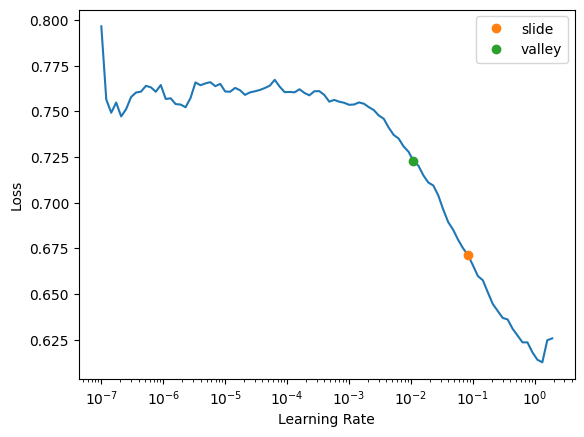

In [17]:
learn.lr_find(suggest_funcs=(slide, valley))

In [18]:
# lr_find: find a good learning rate
# this graph starts with flat learning rate, as small learning rate nothing happens.
# slide: suggest the learning rate where the loss is steepest
# valley: suggest a learning rate where the loss starts to consistently decrease before it increases again
# in general, pick one between the slide and valley will get a pretty good learning rate


In [19]:
learn.fit(16,lr = 0.03)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


epoch,train_loss,valid_loss,accuracy,time
0,0.574149,0.545373,0.730337,00:00
1,0.498414,0.425711,0.780899,00:00
2,0.471779,0.414573,0.797753,00:00
3,0.459436,0.412878,0.803371,00:00
4,0.446336,0.435311,0.814607,00:00
5,0.437281,0.424186,0.808989,00:00
6,0.426120,0.425763,0.814607,00:00
7,0.417197,0.414246,0.814607,00:00
8,0.408943,0.419316,0.825843,00:00
9,0.405296,0.419918,0.825843,00:00


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

## Get prediction

In [22]:
path_test = "test.csv"
df_test = pd.read_csv(path_test)
df_test['Fare']=df_test['Fare'].fillna(0)
add_features(df_test)

In [23]:
test_dl = learn.dls.test_dl(df_test)

In [24]:
preds,_ = learn.get_preds(dl=test_dl)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
/usr/local/lib/python3.10/dist-packages/fastai/torch_co

In [25]:
df_test['Survived'] = (preds[:,1]>0.5).int()

In [26]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title,Survived
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q,2.18,NaN,0,True,1,NaN,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S,2.08,NaN,1,False,1,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q,2.37,NaN,0,True,1,NaN,0
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S,2.27,NaN,0,True,1,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S,2.59,NaN,2,False,1,NaN,1
